## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units).  You have been provided a dataset, **accre-gpu-jobs-2022.csv**, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward. 

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.
2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?
3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?
4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?
5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [175]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact, Dropdown

In [2]:
accre_df = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='warn')

b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


there are 2 bad lines, we'll ignore them for now...

In [3]:
accre_df.shape

(336950, 12)

Found this out later, the REQTIME, USEDTIME and USEDMEM are objects, have to remove junk and convert them by using the to_timedelta function:

In [4]:
accre_df['USEDMEM'] = accre_df['USEDMEM'].str.replace(r'M','', regex=True).astype(float)

accre_df['REQTIME'] = pd.to_timedelta(accre_df['REQTIME'].str.replace(r'-',' days ', regex=True))
accre_df['USEDTIME'] = pd.to_timedelta(accre_df['USEDTIME'].str.replace(r'-',' days ', regex=True))

We (pizza group) also decided to split up the dataframe. Dropping all of the running and pending jobs first (being 1258)

In [5]:
accre_df = accre_df[~accre_df['STATE'].isin(['RUNNING','PENDING'])]

up next, we decided to save the cancelled jobs in a separate dataframe. After that, just to make sure it contains only cancelled in various forms:

`pd.unique(accre_cancelled['STATE'])`

In [6]:
accre_cancelled = accre_df[~accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

And finally, the dataframe that we will be using for most of our analysis (only status codes COMPLETED, FAILED or OUT OF MEMORY)

In [7]:
accre_df = accre_df[accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

In [8]:
accre_df.shape

(283776, 12)

By doing all that, we got rid of 53174 rows!

### Onto some exploration regarding to the very first point

We've actually done some of this analysis before; but after reformatting the notebook it's now here. How many jobs have used 0 memory (because they ran less than 2 min or otherwise):

`accre_df.groupby('USEDMEM').count()`

`accre_df[(accre_df['USEDMEM'] == '0') | (accre_df['USEDMEM'] == '0.00M')]`

Turns out that was 336950 jobs (0 or 0.00M)

In [9]:
accre_noM = accre_df[(accre_df['USEDMEM'] != '0') & (accre_df['USEDMEM'] != '0.00M')]

In [10]:
accre_noM.shape

(283776, 12)

After the cleanup from earlier, we only got rid of 5919 jobs here. That is important because some of them had runtimes which would affect the analysis. Initially did some additional exploration into various errors and codes; omitted here.

In [11]:
accre_noM[accre_noM['STATE'] == 'OUT_OF_MEMORY']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
332639,46247498,glasshouse,tommie,138663.87,5 days 00:00:00,0 days 18:01:08,2,24,8,turing,0:125,OUT_OF_MEMORY
333434,46329470,pasilla,venus,7.19,0 days 00:30:00,0 days 00:05:05,1,1,1,turing,0:125,OUT_OF_MEMORY
334513,46514679,glasshouse,arnoldo,24221.36,0 days 04:00:00,0 days 01:11:23,1,6,1,turing,0:125,OUT_OF_MEMORY


kind of interesting that a job failed with only 7.19M usage and 5 minutes of run time.

After checking out the # of nodes, decided to look into the biggest one:
`accre_noM.groupby('NODES').count()`

In [13]:
accre_noM[accre_noM['NODES'] == 15]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
62122,37020263,pasilla,dola,2.53,0 days 00:20:00,0 days 00:00:03,15,120,60,pascal,0:0,COMPLETED
270301,44976228,pasilla,dola,7.41,0 days 00:20:00,0 days 00:00:02,15,120,60,pascal,0:0,COMPLETED


Another interesting observation here that there were 2 jobs, from the same account and user who required 15 nodes (60) gpus; much more than anyone else!

Back to the question ... My understanding of the question is to have memory/gpu * time(job)/time(total) - got confirmed by Eric that is in fact the case

In [14]:
accre_noM.groupby('PARTITION')['USEDTIME'].sum()

PARTITION
maxwell   2642 days 03:08:29
pascal    9780 days 21:19:05
turing    6407 days 15:58:37
Name: USEDTIME, dtype: timedelta64[ns]

In [15]:
accre_noM['TOT_USEDTIME_PART'] = accre_noM.groupby('PARTITION')['USEDTIME'].transform('sum').to_frame()

In [16]:
accre_noM['WEIGHTED_MEM_GPU'] = (
    (accre_noM['USEDMEM']/ accre_noM['GPUS']) *
    (accre_noM['USEDTIME']/accre_noM['TOT_USEDTIME_PART'])
)

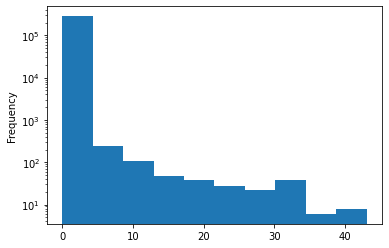

In [17]:
plt.axis
accre_noM['WEIGHTED_MEM_GPU'].plot(kind='hist', log='True');

Very heavy skew visible above -> meaning that most jobs take only a fraction of total time (per partition) and/or use very little memory. Let's compare partitions.

In [18]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].sum()

PARTITION
maxwell    2297.826032
pascal     2751.601922
turing     9277.105272
Name: WEIGHTED_MEM_GPU, dtype: float64

Even though more time (overall) was spent on Pascal than Turing, the memory usage of the latter one prevails. It's also interesting how close together Maxwell and Pascal are. Also, using the describe below, we can see how heavily the data is skewed.

In [19]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,127160.0,0.018070,0.477414,0.0,2.426843e-07,0.000904,0.001294,42.982171
pascal,81544.0,0.033744,0.379766,0.0,5.820515e-05,0.000834,0.002996,26.793911
turing,75072.0,0.123576,1.181682,0.0,1.873841e-07,0.000754,0.002275,43.074130


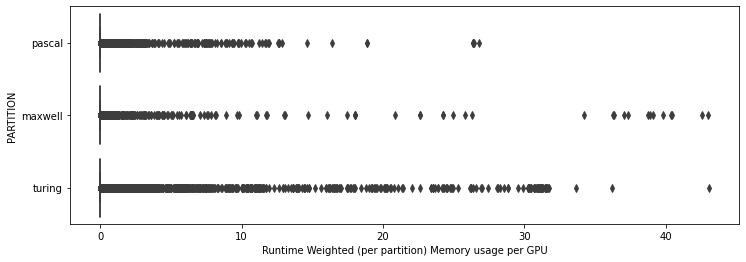

In [20]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=accre_noM, 
            x='WEIGHTED_MEM_GPU', 
            y='PARTITION', 
            ax=ax
)
plt.xlabel('Runtime Weighted (per partition) Memory usage per GPU');

Lots of outliers!!! plotting below by not showing the outliers:

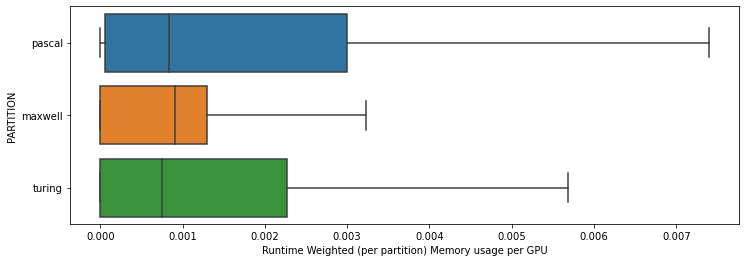

In [21]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=accre_noM, 
            x='WEIGHTED_MEM_GPU', 
            y='PARTITION', 
            ax=ax,
            showfliers = False
)
plt.xlabel('Runtime Weighted (per partition) Memory usage per GPU');

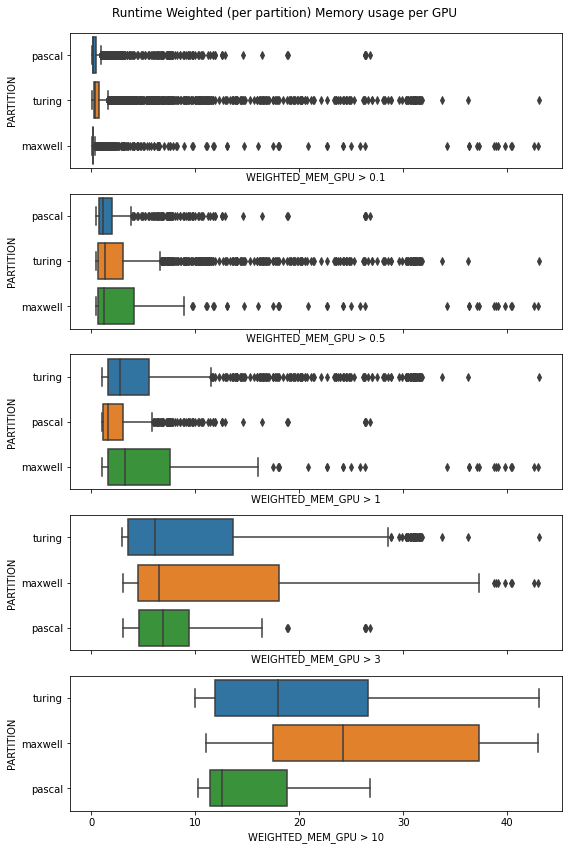

In [22]:
#Trying to plot the above by making cuts at different values
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Runtime Weighted (per partition) Memory usage per GPU')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[0]
)
axes[0].set_xlabel('WEIGHTED_MEM_GPU > 0.1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.5], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[1]
)
axes[1].set_xlabel('WEIGHTED_MEM_GPU > 0.5')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[2]
)
axes[2].set_xlabel('WEIGHTED_MEM_GPU > 1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>3], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[3]
)
axes[3].set_xlabel('WEIGHTED_MEM_GPU > 3')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>10], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[4]
)
axes[4].set_xlabel('WEIGHTED_MEM_GPU > 10')

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### Some exploration into the requested vs used time

In [23]:
accre_df['DELTATIME'] = accre_df['REQTIME'] - accre_df['USEDTIME']

In [24]:
accre_df['REQSEC'] = [x.total_seconds() for x in accre_df['REQTIME']]
accre_df['USEDSEC'] = [x.total_seconds() for x in accre_df['USEDTIME']]
accre_df['DELTASEC'] = [x.total_seconds() for x in accre_df['DELTATIME']]

First off, with the code above, create new columns; one has the difference of time requested minus time used, the other three are converted in seconds.

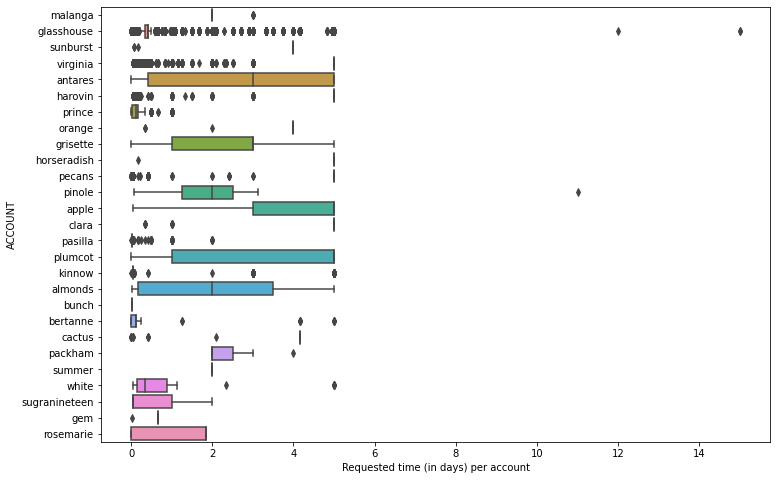

In [25]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df, 
            x=accre_df['REQSEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Requested time (in days) per account');

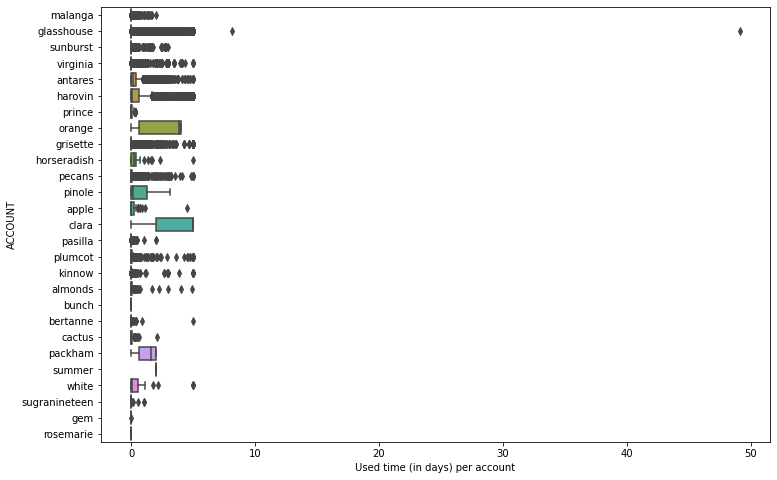

In [26]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df, 
            x=accre_df['USEDSEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Used time (in days) per account');

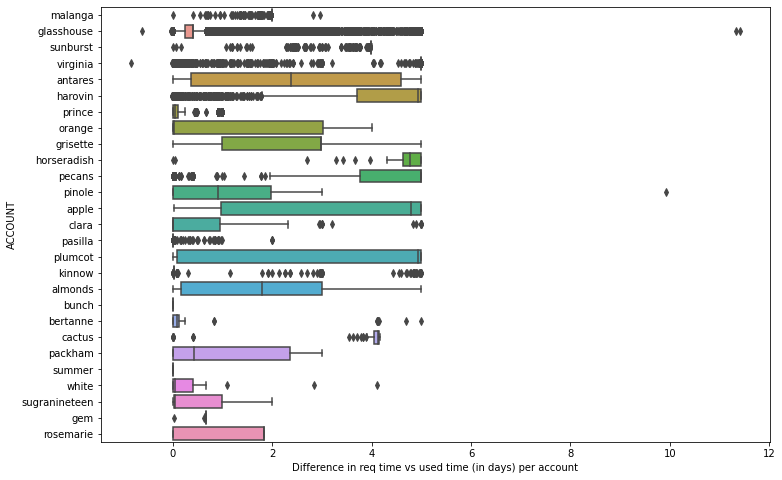

In [27]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[accre_df['JOBID'] != '45364680'], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account');

From the above plots once again, very heavy skew is evident, especialy in certain accounts. Below exploring specificly the situation where the used time was bigger than requested:

In [28]:
accre_df[accre_df['DELTASEC'] < 0].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,DELTATIME,REQSEC,USEDSEC,DELTASEC
count,2914.000000,2914,2914,2914.000000,2914.000000,2914.000000,2914,2914.000000,2.914000e+03,2.914000e+03
mean,8759.580213,2 days 01:43:06.403568977,2 days 02:08:26.289636238,1.014756,4.070350,1.539121,-1 days +23:34:40.113932739,178986.403569,1.805063e+05,-1.519886e+03
std,29205.961130,2 days 02:13:56.424503923,2 days 06:24:11.700581402,0.199867,4.748844,1.578264,0 days 21:46:02.240706673,180836.424504,1.958517e+05,7.836224e+04
min,0.000000,0 days 00:01:00,0 days 00:01:01,1.000000,1.000000,1.000000,-49 days +01:13:05,60.000000,6.100000e+01,-4.229215e+06
25%,263.707500,0 days 04:00:00,0 days 04:00:04,1.000000,1.000000,1.000000,-1 days +23:59:34,14400.000000,1.440400e+04,-2.600000e+01
50%,2404.635000,1 days 00:00:00,1 days 00:00:29,1.000000,2.000000,1.000000,-1 days +23:59:41,86400.000000,8.642900e+04,-1.900000e+01
75%,5600.630000,5 days 00:00:00,5 days 00:00:03,1.000000,6.000000,1.000000,-1 days +23:59:50,432000.000000,4.320030e+05,-1.000000e+01
max,371247.350000,5 days 00:00:00,49 days 02:46:55,7.000000,60.000000,32.000000,-1 days +23:59:59,432000.000000,4.243615e+06,-1.000000e+00


In [29]:
accre_df[accre_df['DELTASEC'] <= 0].groupby(['PARTITION', 'ACCOUNT']).count().sort_values('JOBID', ascending=False)

JOBID  USER  USEDMEM  REQTIME  USEDTIME  NODES  CPUS  \
PARTITION ACCOUNT                                                               
pascal    glasshouse       714   714      714      714       714    714   714   
          prince           683   683      683      683       683    683   683   
turing    harovin          343   343      343      343       343    343   343   
          virginia         341   341      341      341       341    341   341   
pascal    virginia         219   219      219      219       219    219   219   
turing    glasshouse       195   195      195      195       195    195   195   
maxwell   glasshouse       178   178      178      178       178    178   178   
pascal    grisette          55    55       55       55        55     55    55   
          antares           47    47       47       47        47     47    47   
maxwell   clara             46    46       46       46        46     46    46   
          orange            35    35       35       35        35     35    35   
          plumcot           13    13       13       13        13     13    13   
pascal    pecans            11    11       11       11        11     11    11   
turing    pasilla           11    11       11       11        11     11    11   
pascal    rosemarie         10    10       10       10        10     10    10   
          kinnow             9     9        9        9         9      9     9   
maxwell   white              9     9        9        9         9      9     9   
turing    pinole             9     9        9        9         9      9     9   
          almonds            9     9        9        9         9      9     9   
          cactus             4     4        4        4         4      4     4   
          bertanne           4     4        4        4         4      4     4   
pascal    packham            3     3        3        3         3      3     3   
turing    sugranineteen      2     2        2        2         2      2     2   
maxwell   bertanne           2     2        2        2         2      2     2   
pascal    pasilla            2     2        2        2         2      2     2   
          sunburst           1     1        1        1         1      1     1   
          malanga            1     1        1        1         1      1     1   
          horseradish        1     1        1        1         1      1     1   
maxwell   summer             1     1        1        1         1      1     1   
          pasilla            1     1        1        1         1      1     1   

                         GPUS  EXITCODE  STATE  DELTATIME  REQSEC  USEDSEC  \
PARTITION ACCOUNT                                                            
pascal    glasshouse      714       714    714        714     714      714   
          prince          683       683    683        683     683      683   
turing    harovin         343       343    343        343     343      343   
          virginia        341       341    341        341     341      341   
pascal    virginia        219       219    219        219     219      219   
turing    glasshouse      195       195    195        195     195      195   
maxwell   glasshouse      178       178    178        178     178      178   
pascal    grisette         55        55     55         55      55       55   
          antares          47        47     47         47      47       47   
maxwell   clara            46        46     46         46      46       46   
          orange           35        35     35         35      35       35   
          plumcot          13        13     13         13      13       13   
pascal    pecans           11        11     11         11      11       11   
turing    pasilla          11        11     11         11      11       11   
pascal    rosemarie        10        10     10         10      10       10   
          kinnow            9         9      9          9       9        9   
maxwell   white             

Comment on above: there are 2914 (2959 if counting the ones where it was equal) jobs where the used time was more than requested. 285 in Maxwell, 1720 in pascal and 909 in turing. Above is also a breakdown per Account.

In [30]:
accre_df[accre_df['DELTASEC'] < -3600]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,DELTATIME,REQSEC,USEDSEC,DELTASEC
65652,38189174,virginia,anitra,16709.34,2 days 00:00:00,2 days 20:03:53,1,12,2,turing,0:0,COMPLETED,-1 days +03:56:07,172800.0,245033.0,-72233.0
179215,44308490,glasshouse,minor,14203.65,0 days 16:00:00,1 days 06:57:20,1,6,1,turing,0:0,COMPLETED,-1 days +09:02:40,57600.0,111440.0,-53840.0
317705,45364680,glasshouse,daryl,0.00,0 days 04:00:00,49 days 02:46:55,1,2,1,pascal,0:0,FAILED,-49 days +01:13:05,14400.0,4243615.0,-4229215.0


Only 3 jobs go over an hour of requested time; two of which successfully completed. We were later told by Eric that it likely typically takes a few seconds for the scheduler to cut off a job that was running longer than requested. Lets now look at jobs that requested the max time of 5 days (excluding any exceptions over that).

In [31]:
accre_df.loc[accre_df['REQTIME'] == '5 days 00:00:00']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,DELTATIME,REQSEC,USEDSEC,DELTASEC
327,32884086,glasshouse,miya,374.89,5 days,1 days 08:38:34,1,1,1,pascal,0:0,COMPLETED,3 days 15:21:26,432000.0,117514.0,314486.0
1063,32891995,glasshouse,erick,242.00,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,0 days 04:15:29,432000.0,416671.0,15329.0
1064,32891996,glasshouse,erick,244.33,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,0 days 04:15:29,432000.0,416671.0,15329.0
1065,32891997,glasshouse,erick,243.17,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,0 days 04:15:29,432000.0,416671.0,15329.0
1066,32891998,glasshouse,erick,243.82,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,0 days 04:15:29,432000.0,416671.0,15329.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336929,46753800,harovin,shannon,160.03,5 days,0 days 00:00:37,1,1,1,turing,0:0,COMPLETED,4 days 23:59:23,432000.0,37.0,431963.0
336933,46753813,harovin,shannon,137.96,5 days,0 days 00:00:52,1,1,1,turing,0:0,COMPLETED,4 days 23:59:08,432000.0,52.0,431948.0
336934,46753820_26,harovin,porsha,5093.70,5 days,0 days 00:34:51,1,6,1,turing,0:0,COMPLETED,4 days 23:25:09,432000.0,2091.0,429909.0
336936,46753823,harovin,shannon,156.21,5 days,0 days 00:04:03,1,1,1,turing,0:0,COMPLETED,4 days 23:55:57,432000.0,243.0,431757.0


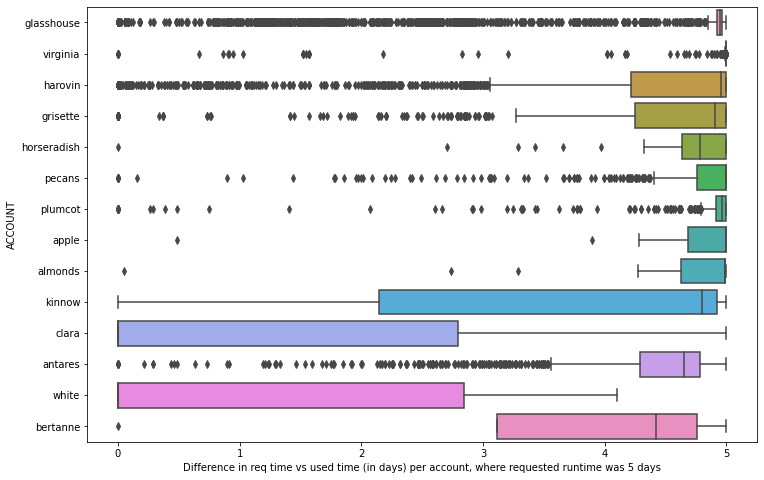

In [32]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[accre_df['REQTIME'] == '5 days 00:00:00'], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account, where requested runtime was 5 days');

To look at it better, how many of those accounts actually took at least 4 days to run? Or in other words, the time run was within 1 day of requested time.

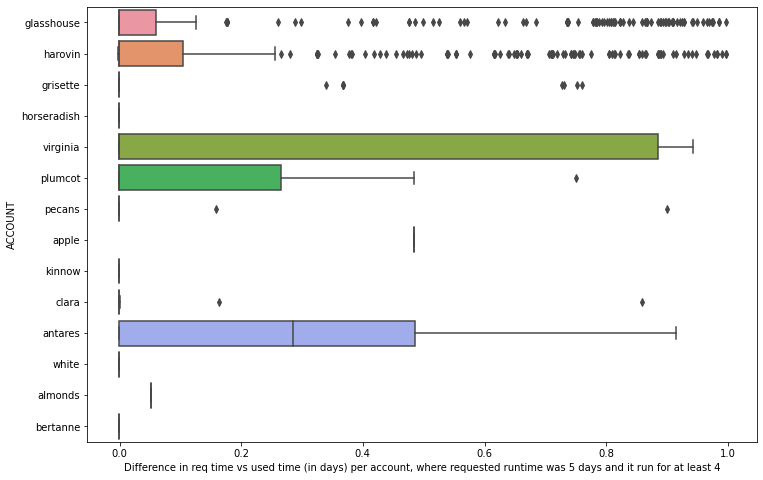

In [33]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[(accre_df['REQTIME'] == '5 days 00:00:00')
                          & (accre_df['DELTASEC']/ 86400 < 1)], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account, where requested runtime was 5 days and it run for at least 4');

Let's explore just the ones that ran over.

In [34]:
accre_df[(accre_df['REQTIME'] == '5 days 00:00:00') & (accre_df['DELTASEC'] < 0)].sort_values('USEDTIME', ascending = False)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,DELTATIME,REQSEC,USEDSEC,DELTASEC
330597,45754711_9,harovin,porsha,17932.89,5 days,5 days 00:04:26,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:34,432000.0,432266.0,-266.0
330598,45754711_10,harovin,porsha,18744.37,5 days,5 days 00:04:25,1,6,1,turing,0:0,COMPLETED,-1 days +23:55:35,432000.0,432265.0,-265.0
59290,35860195,harovin,porsha,4045.17,5 days,5 days 00:02:24,1,3,1,turing,0:0,COMPLETED,-1 days +23:57:36,432000.0,432144.0,-144.0
59321,35863149,harovin,porsha,4550.14,5 days,5 days 00:01:21,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:39,432000.0,432081.0,-81.0
60349,36303220_30,harovin,porsha,3938.44,5 days,5 days 00:01:14,1,3,1,turing,0:0,COMPLETED,-1 days +23:58:46,432000.0,432074.0,-74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332126,46043918_6,harovin,porsha,39056.30,5 days,5 days 00:00:01,1,6,1,turing,0:0,COMPLETED,-1 days +23:59:59,432000.0,432001.0,-1.0
71204,38951964,clara,suzanna,479.51,5 days,5 days 00:00:01,1,3,1,maxwell,0:0,COMPLETED,-1 days +23:59:59,432000.0,432001.0,-1.0
325645,45516891,glasshouse,jolette,299.33,5 days,5 days 00:00:01,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:59,432000.0,432001.0,-1.0
325650,45516896,glasshouse,jolette,300.01,5 days,5 days 00:00:01,1,1,1,pascal,0:0,COMPLETED,-1 days +23:59:59,432000.0,432001.0,-1.0


In [36]:
( accre_df
    [(accre_df['REQTIME'] == '5 days 00:00:00') & (accre_df['DELTASEC'] < 0)]
    .groupby(['PARTITION','ACCOUNT', 'USER'])
    ['DELTASEC']
    .describe()
)

count       mean        std    min    25%  \
PARTITION ACCOUNT     USER                                                   
maxwell   clara       suzanna     30.0 -15.600000   8.896338  -28.0 -23.75   
          glasshouse  erick       37.0 -15.621622   5.633981  -29.0 -19.00   
                      jolette     43.0 -19.953488   4.745692  -23.0 -23.00   
          plumcot     porsha       7.0 -24.428571   5.094348  -32.0 -28.50   
                      shannon      1.0 -17.000000        NaN  -17.0 -17.00   
                      trevion      4.0 -10.000000   0.000000  -10.0 -10.00   
          white       brittani     3.0  -9.333333  10.115994  -21.0 -12.50   
pascal    antares     nakisha      7.0 -15.428571   9.947481  -28.0 -22.50   
          glasshouse  andra       27.0 -13.000000   9.085068  -30.0 -19.50   
                      birdella    16.0 -17.250000   8.858141  -32.0 -25.00   
                      collins      1.0  -4.000000        NaN   -4.0  -4.00   
                      erick       10.0 -11.700000   5.578729  -20.0 -15.00   
                      jolette    166.0 -14.590361   8.992975  -29.0 -23.00   
                      jonnie      17.0 -38.176471   8.323425  -53.0 -44.00   
                      lea          3.0 -23.333333  16.041613  -40.0 -31.00   
          grisette    debera      12.0 -14.666667   8.742096  -26.0 -24.00   
                      hjalmar     11.0 -21.818182   9.693484  -37.0 -29.00   
                      kash         5.0 -10.600000   9.289779  -25.0 -15.00   
          horseradish trudi        1.0 -13.000000        NaN  -13.0 -13.00   
          kinnow      valentina    7.0 -20.142857   9.281318  -29.0 -26.50   
          pecans      glenda       2.0 -19.000000  15.556349  -30.0 -24.50   
                      nobie        6.0 -13.666667  10.519823  -28.0 -22.00   
          virginia    earlean      6.0 -18.833333   7.884584  -27.0 -25.25   
turing    bertanne    vaughn       1.0  -7.000000        NaN   -7.0  -7.00   
          harovin     porsha     268.0 -22.638060  26.664646 -266.0 -27.00   
                      shannon     16.0 -16.937500   9.476066  -35.0 -22.25   
                      valentina   44.0 -14.136364   8.590397  -31.0 -22.00   

                                  50%    75%   max  
PARTITION ACCOUNT     USER                          
maxwell   clara       suzanna   -17.5  -7.00  -1.0  
          glasshouse  erick     -16.0 -16.00  -6.0  
                      jolette   -23.0 -16.00  -4.0  
          plumcot     porsha    -22.0 -20.00 -20.0  
                      shannon   -17.0 -17.00 -17.0  
                      trevion   -10.0 -10.00 -10.0  
          white       brittani   -4.0  -3.50  -3.0  
pascal    antares     nakisha   -16.0  -9.00  -1.0  
          glasshouse  andra     -10.0  -5.00  -2.0  
                      birdella  -14.0 -10.00  -7.0  
                      collins    -4.0  -4.00  -4.0  
                      erick     -15.0  -5.50  -5.0  
                      jolette   -13.5  -5.25  -1.0  
                      jonnie    -35.0 -33.00 -27.0  
                      lea       -22.0 -15.00  -8.0  
          grisette    debera    -15.5  -6.00  -2.0  
                      hjalmar   -22.0 -15.00  -4.0  
                      kash       -5.0  -4.00  -4.0  
          horseradish trudi     -13.0 -13.00 -13.0  
          kinnow      valentina -25.0 -14.50  -5.0  
          pecans      glenda    -19.0 -13.50  -8.0  
                      nobie      -9.0  -5.75  -5.0  
          virginia    earlean   -20.5 -12.00  -9.0  
turing    bertanne    vaughn     -7.0  -7.00  -7.0  
          harovin     porsha    -18.5  -9.75  -1.0  
                      shannon   -15.5 -13.25  -2.0  
                      valentina -14.5  -6.00  -3.0

looking at the numbers above it becomes clear that even the jobs that ran for 5 days went only a few minutes over.

In [212]:
accre_df.groupby(['PARTITION', 'ACCOUNT']).max('USEDMEM').sort_values('USEDMEM', ascending=False).head()

USEDMEM  NODES  CPUS  GPUS     REQSEC    USEDSEC  \
PARTITION ACCOUNT                                                          
turing    virginia    371247.35      1    24     4   432000.0   374580.0   
          glasshouse  310280.90      5    69    20   432000.0   377214.0   
pascal    virginia    248467.89      1     8     4   432000.0   432027.0   
          glasshouse  246085.25      7    49    32  1036800.0  4243615.0   
turing    pinole      184807.43      1    12     2   950400.0   270029.0   

                      DELTASEC  USEDMEM_PERSEC  JOBS_ACCOUNT  JOBS_USER  
PARTITION ACCOUNT                                                        
turing    virginia    431995.0      473.281486           624        165  
          glasshouse  431997.0     2114.027500         68498      58931  
pascal    virginia    431993.0      586.255556          8932       8413  
          glasshouse  432000.0             inf         43380      24777  
turing    pinole      857046.0       85.017160            19         10

Now looking into the GPU usage

In [211]:
accre_df.groupby(['PARTITION', 'ACCOUNT']).max('GPUS').sort_values('GPUS', ascending=False).head()

,,USEDMEM,NODES,CPUS,GPUS,REQSEC,USEDSEC,DELTASEC,USEDMEM_PERSEC,JOBS_ACCOUNT,JOBS_USER
PARTITION,ACCOUNT,,,,,,,,,,
pascal,pasilla,120.90,15,120,60,172800.0,172816.0,14293.0,3.705,425,422
turing,pasilla,176687.27,10,80,40,172800.0,86417.0,172414.0,inf,479,424
maxwell,pasilla,5612.62,10,80,40,172800.0,3627.0,172423.0,11.730,431,423
pascal,glasshouse,246085.25,7,49,32,1036800.0,4243615.0,432000.0,inf,43380,24777
maxwell,glasshouse,108395.95,9,70,30,1296000.0,432029.0,985570.0,inf,125492,112903


### Additional Exploration

After we had a team discussion and division of questions, I decided to try and have a look at different users by weighing the used memory with used time. Essentially, to see if there are any abnormal speaks or some other interesting trends there.

In [43]:
accre_df['USEDMEM_PERSEC'] = accre_df['USEDMEM']/accre_df['USEDSEC']

In [44]:
accre_df.loc[np.isinf(accre_df['USEDMEM_PERSEC'])]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,DELTATIME,REQSEC,USEDSEC,DELTASEC,USEDMEM_PERSEC
62129,37025197,glasshouse,collier,7.64,3 days 08:00:00,0 days,2,6,12,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62131,37025214,glasshouse,collier,7.64,3 days 08:00:00,0 days,2,6,12,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62132,37025216,glasshouse,collier,7.64,3 days 08:00:00,0 days,1,3,8,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62134,37025239,glasshouse,collier,7.64,3 days 08:00:00,0 days,1,3,8,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62236,37031751,glasshouse,collier,7.64,3 days 08:00:00,0 days,2,6,12,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62548,37085854,glasshouse,collier,7.61,3 days 08:00:00,0 days,2,6,12,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62641,37146722,glasshouse,collins,5.55,0 days 10:00:00,0 days,1,1,1,pascal,33:0,FAILED,0 days 10:00:00,36000.0,0.0,36000.0,inf
62642,37146742,glasshouse,collins,5.55,0 days 10:00:00,0 days,1,1,1,pascal,33:0,FAILED,0 days 10:00:00,36000.0,0.0,36000.0,inf
62928,37204949,glasshouse,collier,7.61,3 days 08:00:00,0 days,2,6,12,maxwell,0:0,COMPLETED,3 days 08:00:00,288000.0,0.0,288000.0,inf
62932,37204975,pasilla,gibson,33795.00,0 days 12:00:00,0 days,1,24,4,turing,0:0,COMPLETED,0 days 12:00:00,43200.0,0.0,43200.0,inf


In [45]:
accre_df.loc[np.isinf(accre_df['USEDMEM_PERSEC'])]['USEDMEM'].sum()

35161.74

#### interesting find

So there are 27 jobs (12 completed, 15 failed) that allegedly ran for 0 seconds and yet used memory. Bizzarre.

101 jobs where both memory and seconds are 0 (therefore mem/sec is NaN). I decided that for those, I can set the value of mem/sec to 0.
`accre_df.loc[accre_df['USEDMEM_PERSEC'].isnull()]` to check

In [214]:
# set the NaN values to 0 this is an option
# accre_df.loc[accre_df['USEDMEM_PERSEC'].isnull()] = 0

# or this 
accre_df['USEDMEM_PERSEC'] = accre_df['USEDMEM_PERSEC'].fillna(0)

I will kip the inf in the dataframe, but will not count them for any calculations from now on, since there is something ele going on there!

NOT NEEDED - keeping it here just in case

`accre_df['JOBS_ACCOUNT'] = accre_df.groupby(['PARTITION', 'ACCOUNT'])['JOBID'].transform('count')`

`accre_df['JOBS_USER'] = accre_df.groupby(['PARTITION', 'ACCOUNT', 'USER'])['JOBID'].transform('count')`

In [48]:
accre_maxwell = accre_df[accre_df['PARTITION'] == 'maxwell']
accre_pascal = accre_df[accre_df['PARTITION'] == 'pascal']
accre_turing = accre_df[accre_df['PARTITION'] == 'turing']

I was doing various plot below, like:
```
plt.figure(figsize = (8,5))
accre_maxwell.value_counts('USER').head().plot(kind='bar');
```
and
```
plt.figure(figsize = (8,5))
accre_maxwell.groupby('USER')['DELTASEC'].sum().sort_values(ascending=False).head().plot(kind='bar');
```
And similar, but for ACCOUNT instead of USER. To kind of see who the 'top' users and accounts are and noticing they change. Meaning, the accounts with most jobs don't necessarily have the highest mem/time usage.

Idea: maybe compare the different acounts just by # of jobs, then total memory usage and total time usage. Plots like:
```
sns.scatterplot(x=accre_maxwell.value_counts('ACCOUNT'),
               y=accre_maxwell.groupby('ACCOUNT')['DELTASEC'].sum());
```
and
```
sns.scatterplot(x=accre_pascal.value_counts('ACCOUNT'),
               y=accre_pascal.groupby('ACCOUNT')['DELTASEC'].sum().sort_values(ascending=False));
```
Not revealed anything interesting.

### more of my own ideas for exploration

Code to exclude the infinite values

`accre_df.loc[np.isfinite(accre_df['USEDMEM_PERSEC'])]`

By executing the below code I found out that 8 jobs with memory and 0 runtime were on Maxwell, 17 on Pascal and 2 on Turing.

`accre_maxwell.loc[np.isinf(accre_maxwell['USEDMEM_PERSEC'])].shape`
`accre_pascal.loc[np.isinf(accre_pascal['USEDMEM_PERSEC'])].shape`
`accre_turing.loc[np.isinf(accre_turing['USEDMEM_PERSEC'])].shape`

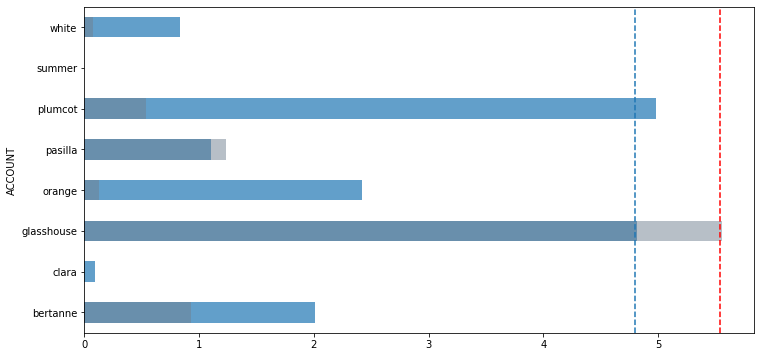

In [71]:
plt.figure(figsize = (12,6))

(accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby('ACCOUNT')['USEDMEM_PERSEC']
 .mean()
 .plot(kind='barh', alpha=0.7)
)

(accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby('ACCOUNT')['USEDMEM_PERSEC']
 .median()
 .plot(kind='barh', color='slategray', alpha=0.5)
)
 
ymin, ymax = plt.ylim()
plt.vlines(
    x = accre_maxwell
        .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
        ['USEDMEM_PERSEC']
        .mean(),
    ymin = ymin,
    ymax = ymax,
    linestyle = '--'
)

plt.vlines(
    x = accre_maxwell
        .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
        ['USEDMEM_PERSEC']
        .median(),
    ymin = ymin,
    ymax = ymax,
    linestyle = '--',
    color = 'red'
);

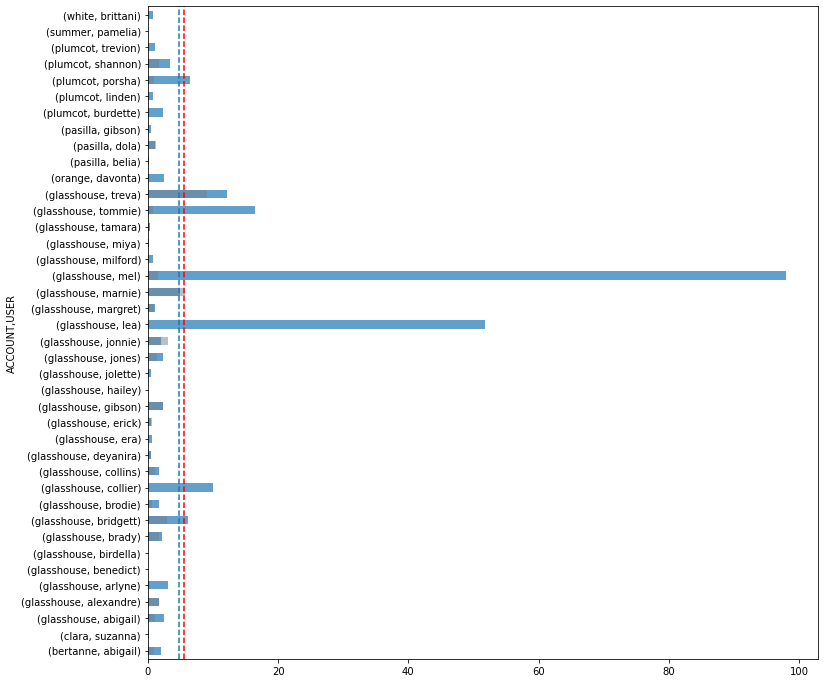

In [72]:
plt.figure(figsize = (12,12))

(accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby(['ACCOUNT', 'USER'])['USEDMEM_PERSEC']
 .mean()
 .plot(kind='barh', alpha=0.7)
)

(accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby(['ACCOUNT', 'USER'])['USEDMEM_PERSEC']
 .median()
 .plot(kind='barh', color='slategray', alpha=0.5)
)
 
ymin, ymax = plt.ylim()
plt.vlines(
    x = accre_maxwell
        .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
        ['USEDMEM_PERSEC']
        .mean(),
    ymin = ymin,
    ymax = ymax,
    linestyle = '--'
)

plt.vlines(
    x = accre_maxwell
        .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
        ['USEDMEM_PERSEC']
        .median(),
    ymin = ymin,
    ymax = ymax,
    linestyle = '--',
    color = 'red'
);

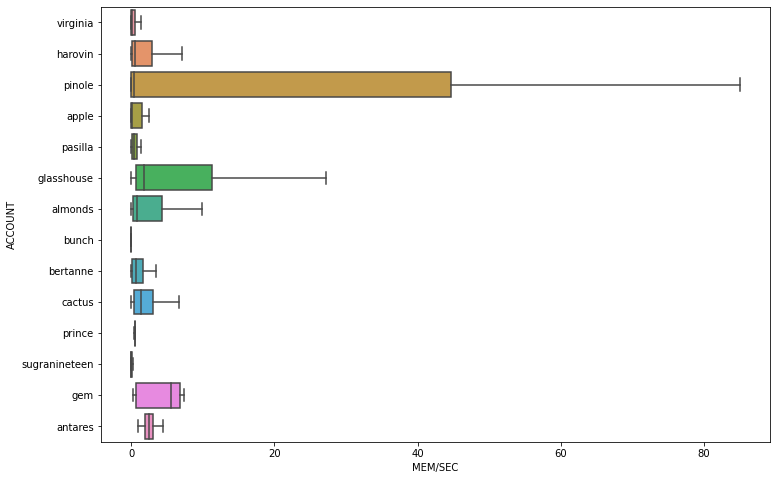

In [76]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_turing.loc[np.isfinite(accre_turing['USEDMEM_PERSEC'])],
            x='USEDMEM_PERSEC', 
            y='ACCOUNT', 
            ax=ax,
            showfliers = False
)
plt.xlabel('MEM/SEC');

Dabbled with various plot like above for different Partitions and after talking to Michael he helped me confirm that these graphs don't represent well the data due to the enormous skew.

This was old code (before having a separate column for the division):
```
plt.figure(figsize = (12,6))
(
 (accre_turing
  .groupby('ACCOUNT')['USEDMEM']
  .sum()
  /
  accre_turing
  .groupby('ACCOUNT')['USEDSEC']
  .sum()
 )
 #.sort_values(ascending=False)
 .plot(kind='barh', alpha =0.7)
)

(
 (accre_turing
  .groupby('ACCOUNT')['USEDMEM']
  .median()
  /
  accre_turing
  .groupby('ACCOUNT')['USEDSEC']
  .median()
 )
 #.sort_values(ascending=False)
 .plot(kind='barh', color='slategray', alpha=0.5)
)

ymin, ymax = plt.ylim()
plt.vlines(x = 0.5206806754685073, ymin = ymin, ymax = ymax, linestyle = '--')
plt.vlines(x = 1.482, ymin = ymin, ymax = ymax, linestyle = '--', color = 'red');
```

and further divided by users:
```
plt.figure(figsize = (12,30))
(
 (accre_turing
  #[accre_turing['USER'] != 'benedict']
  .groupby(['ACCOUNT','USER'])['USEDMEM']
  .sum()
  /
  accre_turing
  #[accre_turing['USER'] != 'benedict']
  .groupby(['ACCOUNT','USER'])['USEDSEC']
  .sum()
 )
 #.sort_values(ascending=False)
 #.head(20)
 .plot(kind='barh', alpha=0.7)
)

(
 (accre_turing
  #[accre_turing['USER'] != 'benedict']
  .groupby(['ACCOUNT','USER'])['USEDMEM']
  .median()
  /
  accre_turing
  #[accre_turing['USER'] != 'benedict']
  .groupby(['ACCOUNT','USER'])['USEDSEC']
  .median()
 )
 #.sort_values(ascending=False)
 #.head(20)
 .plot(kind='barh', color='slategray', alpha=0.5)
)

ymin, ymax = plt.ylim()
plt.vlines(x = 0.5206806754685073, ymin = ymin, ymax = ymax, linestyle = '--')
plt.vlines(x = 1.482, ymin = ymin, ymax = ymax, linestyle = '--', color = 'red');
```

In [113]:
(accre_pascal
 .loc[np.isfinite(accre_pascal['USEDMEM_PERSEC'])]
 .groupby(['ACCOUNT', 'USER'])
 ['USEDMEM_PERSEC']
 .describe(percentiles=[.1, .25, .5, .75, .9])
 .sort_values('count', ascending=False)
 .head(10)
)

count       mean        std       min       10%  \
ACCOUNT    USER                                                            
glasshouse marnie      24777.0   6.313304   2.734682  0.000000  0.790000   
malanga    arline       9851.0   0.060397   0.109500  0.000000  0.000000   
virginia   hillery      8413.0   5.677575   0.652511  0.000000  5.045615   
prince     wilhelmina   7403.0  10.651599  21.981295  0.000000  0.318000   
glasshouse collins      7111.0   1.474012   1.750383  0.000000  0.004316   
           treva        3185.0   7.884367  12.729351  0.000000  0.676364   
           erick        2840.0   0.259762   0.577432  0.000000  0.001711   
antares    nakisha      2626.0   3.392569  12.614200  0.000000  0.035661   
grisette   hjalmar      2492.0   6.514247   6.327911  0.000000  0.000000   
           marilee      1609.0   0.884705   0.236162  0.021111  0.650266   

                            25%       50%        75%        90%         max  
ACCOUNT    USER                                                              
glasshouse marnie      5.974466  6.772274   8.079390   8.920022   75.835000  
malanga    arline      0.020100  0.026319   0.070297   0.166883    3.188297  
virginia   hillery     5.368365  5.704152   6.041645   6.377012    8.314507  
prince     wilhelmina  0.614571  1.839452  10.412564  31.839714  515.844615  
glasshouse collins     0.791429  1.316903   2.090033   2.880939   80.316875  
           treva       1.488989  5.283086   8.006950  17.669666  185.404000  
           erick       0.046755  0.049531   0.058454   1.049882    6.090500  
antares    nakisha     0.103184  0.272122   1.626792   3.862564  139.295294  
grisette   hjalmar     0.921647  2.071434  11.787883  14.449414   47.968704  
           marilee     0.800321  0.934563   1.003935   1.058791    2.131667

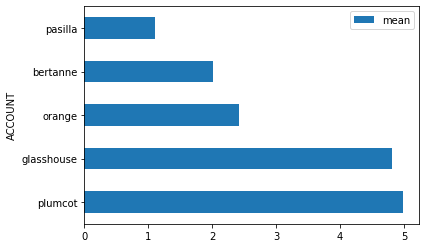

In [185]:
order_by = 'mean'

(accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby('ACCOUNT')
 ['USEDMEM_PERSEC']
 .describe(percentiles=[.1, .25, .5, .75, .9])
 .sort_values(f'{order_by}', ascending=False)
 .head(5)
 .plot(kind='barh', y=f'{order_by}')
);

In [186]:
order_by = 'mean'

accre_describe = (accre_maxwell
 .loc[np.isfinite(accre_maxwell['USEDMEM_PERSEC'])]
 .groupby('ACCOUNT')
 ['USEDMEM_PERSEC']
 .describe(percentiles=[.1, .25, .5, .75, .9])
 .sort_values(f'{order_by}', ascending=False)
 .head(5)
 .reset_index()
)

fig = px.scatter(accre_describe, y='ACCOUNT', x=['10%','mean', '50%','90%'])
fig.update_traces(marker_size=10)
fig.show()

### Final portions of the analysis

time to clean up some code above by making a function!

In [207]:
def describe_partition(partition, group_by='ACCOUNT', variable='USEDMEM_PERSEC', order_by='count', top_n=5):

    return (partition
             .loc[np.isfinite(partition['USEDMEM_PERSEC'])]
             .groupby(group_by)
             [variable]
             .describe(percentiles=[.1, .25, .5, .75, .9])
             .sort_values(f'{order_by}', ascending=False)
             .head(top_n)
            )

For partition there are three options:
- accre_maxwell
- accre_pascal
- accre_turing

For grouping by:
- 'ACCOUNT' (default)
- ['ACCOUNT', 'USER'] if we want to specify users by groups
- 'USER' if we don't care the user can be under multiple accounts

For variable the options that likely make the most sense are:
- USEDMEM_PERSEC (default), used memory divided by used time (in seconds)
- USEDMEM, used memory
- USEDSEC, used time (in seconds)

For order_by:
- count (default), total number of jobs
- mean (of the value selected, same for below)
- min
- max
- 10%
- 25%
- 50%
- 75%
- 90%

And finally, top_n is how many accounts or users to display (default 5)

In [216]:
test = describe_partition(
    partition=accre_maxwell,
    group_by='ACCOUNT',
    variable='USEDMEM_PERSEC',
    order_by='count',
    top_n=5)

In [218]:
test

,count,mean,std,min,10%,25%,50%,75%,90%,max
ACCOUNT,,,,,,,,,,
glasshouse,125485.0,4.814786,15.294635,0.000000,0.614444,0.790000,5.555094,6.338972,9.848565,3164.990000
plumcot,1027.0,4.985219,25.170674,0.000000,0.000000,0.008753,0.542000,1.521836,5.498472,349.484333
pasilla,431.0,1.103996,0.716950,0.000000,0.296400,0.823889,1.235000,1.236667,1.482000,11.730000
clara,77.0,0.097880,0.344609,0.000000,0.000383,0.000408,0.000731,0.001728,0.158154,1.870000
orange,74.0,2.421786,9.730316,0.000142,0.004277,0.026575,0.132653,0.303359,1.687107,66.480612


In [217]:
def color_negative_red(value):
    """
    Colors elements in a dateframe
    green if positive and red if
    negative. Does not color NaN
    values.
    """

    if value < 1:
        color = 'red'
    elif value > 4:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

In [220]:
test.style.applymap(color_negative_red, subset=['10%','90%'])

,count,mean,std,min,10%,25%,50%,75%,90%,max
ACCOUNT,,,,,,,,,,
glasshouse,125485.000000,4.814786,15.294635,0.000000,0.614444,0.790000,5.555094,6.338972,9.848565,3164.990000
plumcot,1027.000000,4.985219,25.170674,0.000000,0.000000,0.008753,0.542000,1.521836,5.498472,349.484333
pasilla,431.000000,1.103996,0.716950,0.000000,0.296400,0.823889,1.235000,1.236667,1.482000,11.730000
clara,77.000000,0.097880,0.344609,0.000000,0.000383,0.000408,0.000731,0.001728,0.158154,1.870000
orange,74.000000,2.421786,9.730316,0.000142,0.004277,0.026575,0.132653,0.303359,1.687107,66.480612
